## Logistic Regression Notebook

In [1]:
!pip install -U matplotlib # Install the newest version of matplotlib (requires kernel to be restarted)

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset

In [3]:
Coupon_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
Coupon_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

print(Coupon_train)
print(Coupon_test)

          id  Decision  ... Direction_same Distance
0          1         1  ...              0        2
1          2         0  ...              0        2
2          3         1  ...              0        1
3          4         1  ...              0        1
4          5         1  ...              1        2
...      ...       ...  ...            ...      ...
10179  10180         0  ...              0        2
10180  10181         1  ...              0        1
10181  10182         0  ...              0        2
10182  10183         0  ...              0        1
10183  10184         0  ...              0        1

[10184 rows x 23 columns]
        id       Driving_to  ... Direction_same Distance
0        1  No Urgent Place  ...              0        1
1        2             Home  ...              1        2
2        3  No Urgent Place  ...              0        2
3        4  No Urgent Place  ...              0        2
4        5             Work  ...              1        2
...    

### Data Imputation

In [4]:
# Fill NaN values according to feature distribution
for col in Coupon_train:
  s = Coupon_train[col].value_counts(normalize=True)
  missing = Coupon_train[col].isnull()
  Coupon_train.loc[missing,col] = np.random.choice(s.index, size=len(Coupon_train[missing]),p=s.values)

# Fill NaN values according to feature distribution
for col in Coupon_test:
  s = Coupon_test[col].value_counts(normalize=True)
  missing = Coupon_test[col].isnull()
  Coupon_test.loc[missing,col] = np.random.choice(s.index, size=len(Coupon_test[missing]),p=s.values)

# Nominal Features, Ordinal Features + Frequency Subset
nominal = ['Driving_to','Passanger','Weather','Temperature','Time','Coupon','Coupon_validity','Gender',
           'Age','Maritalstatus','Children','Education','Occupation','Income','Direction_same']
ordinal = ['Bar','Coffeehouse','Carryaway','Restaurantlessthan20','Restaurant20to50','Distance']
frequency = ['Bar','Coffeehouse','Carryaway','Restaurantlessthan20','Restaurant20to50']

# Removing id and Decision from train data
Coupon_train.drop('id', inplace=True, axis=1) # Removing id (redundant)
Decision = Coupon_train['Decision']
Coupon_train.drop('Decision', inplace=True, axis=1)

# Removing id from test data
id = Coupon_test['id'].to_numpy()
Coupon_test.drop('id', inplace=True, axis=1) # Removing id (redundant)

### Label Encoding Ordinal Features

In [5]:
# Training Data
Coupon_train[frequency] = Coupon_train[frequency].astype(int)
Coupon_train['Distance'] = Coupon_train['Distance'].map({1:0, 2:1, 3:0})

# Test Data
Coupon_test[frequency] = Coupon_test[frequency].astype(int)
Coupon_test['Distance'] = Coupon_test['Distance'].map({1:0, 2:1, 3:2})

### One-Hot Encoding Nominal Features

In [6]:
one_hot = OneHotEncoder(sparse=False)

# Training Data
Coupon_train_nominal = pd.DataFrame(one_hot.fit_transform(Coupon_train[nominal]), 
                                    index = np.arange(0,len(Coupon_train[nominal])), 
                                    columns = one_hot.get_feature_names_out(Coupon_train[nominal].columns))
Coupon_train = pd.concat([Decision, Coupon_train[ordinal], Coupon_train_nominal], axis=1)
Coupon_train = Coupon_train.astype(int) # Converting all training labels to int
Coupon_train.drop_duplicates(keep='first', inplace=True) # Drop duplicate labels

# Test Data
Coupon_test_nominal = pd.DataFrame(one_hot.fit_transform(Coupon_test[nominal]), 
                                   index = np.arange(0,len(Coupon_test[nominal])), 
                                   columns = one_hot.get_feature_names_out(Coupon_test[nominal].columns))
Coupon_test = pd.concat([Coupon_test[ordinal], Coupon_test_nominal], axis=1)
Coupon_test = Coupon_test.astype(int) # Converting all test labels to int

print(Coupon_train)
print(Coupon_test)

       Decision  Bar  ...  Direction_same_0  Direction_same_1
0             1    2  ...                 1                 0
1             0    0  ...                 1                 0
2             1    1  ...                 1                 0
3             1    2  ...                 1                 0
4             1    0  ...                 0                 1
...         ...  ...  ...               ...               ...
10179         0    1  ...                 1                 0
10180         1    1  ...                 1                 0
10181         0    3  ...                 1                 0
10182         0    2  ...                 1                 0
10183         0    1  ...                 1                 0

[10136 rows x 91 columns]
      Bar  Coffeehouse  ...  Direction_same_0  Direction_same_1
0       3            1  ...                 1                 0
1       0            3  ...                 0                 1
2       2            1  ...          

### Specifying Training and Test Data

In [7]:
X_train, y_train = Coupon_train.iloc[:, 1:], Coupon_train.iloc[:, 0]
X_test = Coupon_test.iloc[:,:]
print(X_train, '\n', X_test)

       Bar  Coffeehouse  ...  Direction_same_0  Direction_same_1
0        2            0  ...                 1                 0
1        0            1  ...                 1                 0
2        1            1  ...                 1                 0
3        2            0  ...                 1                 0
4        0            0  ...                 0                 1
...    ...          ...  ...               ...               ...
10179    1            0  ...                 1                 0
10180    1            3  ...                 1                 0
10181    3            0  ...                 1                 0
10182    2            3  ...                 1                 0
10183    1            0  ...                 1                 0

[10136 rows x 90 columns] 
       Bar  Coffeehouse  ...  Direction_same_0  Direction_same_1
0       3            1  ...                 1                 0
1       0            3  ...                 0                 1

### **Logistic Regression (sklearn)**

#### Hyperparameter selection through k-fold cross validation

In [8]:
from itertools import product

# Obtaining all possible parameter combinations
parameters = {'penalty': ['l2'],'tol': [1e-3, 1e-4, 1e-5, 1e-6], 'C': [10**-4, 10**-3, 10**-2, 0.1, 1, 10, 100, 1000]}
parameters = [dict(zip(parameters, v)) for v in product(*parameters.values())]

K = 10 # 10-fold cross validation
kf = KFold(n_splits=K, random_state=None, shuffle=False)
eval_params = []

for value, p in enumerate(parameters):
    scores = np.zeros(K)
    i = 0
    if value % 5 == 0: print("Elapsed time: {}/{}".format(value, len(parameters)))

    # Splitting Training Data into 9 training folds and one test fold
    for train_index, test_index in kf.split(X_train):
        X_train_val, X_test_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_val, y_test_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = LogisticRegression(penalty = p['penalty'], tol = p['tol'], C = p['C'], max_iter = 1000)

        # Obtain classification accuracy
        clf = clf.fit(X_train_val, y_train_val)
        y_pred = clf.predict(X_test_val)
        scores[i] = accuracy_score(y_test_val, y_pred)
        i = i + 1

    # Average classification accuracy over folds
    eval_params.append((p['penalty'], p['tol'], p['C'], scores.mean()))

Elapsed time: 0/32
Elapsed time: 5/32
Elapsed time: 10/32
Elapsed time: 15/32
Elapsed time: 20/32
Elapsed time: 25/32
Elapsed time: 30/32


Optimally Tuned Parameters: [penalty, tol, C] =  ['l2' '0.001' '0.1']
Optimal Validation Accuracy: =  0.6831076673851373 

Accuracies for all Parameter Combinations:
[['l2' '0.001' '0.0001' '0.5691589221773746']
 ['l2' '0.001' '0.001' '0.6636739156254685']
 ['l2' '0.001' '0.01' '0.6817271914811591']
 ['l2' '0.001' '0.1' '0.6831076673851373']
 ['l2' '0.001' '1' '0.6829104287263601']
 ['l2' '0.001' '10' '0.6829102340188983']
 ['l2' '0.001' '100' '0.6829101366651674']
 ['l2' '0.001' '1000' '0.6828115173357788']
 ['l2' '0.0001' '0.0001' '0.5691589221773746']
 ['l2' '0.0001' '0.001' '0.6636739156254685']
 ['l2' '0.0001' '0.01' '0.6817271914811591']
 ['l2' '0.0001' '0.1' '0.6831076673851373']
 ['l2' '0.0001' '1' '0.6829104287263601']
 ['l2' '0.0001' '10' '0.6829102340188983']
 ['l2' '0.0001' '100' '0.6829101366651674']
 ['l2' '0.0001' '1000' '0.6828115173357788']
 ['l2' '1e-05' '0.0001' '0.5691589221773746']
 ['l2' '1e-05' '0.001' '0.6636739156254685']
 ['l2' '1e-05' '0.01' '0.68172719148115

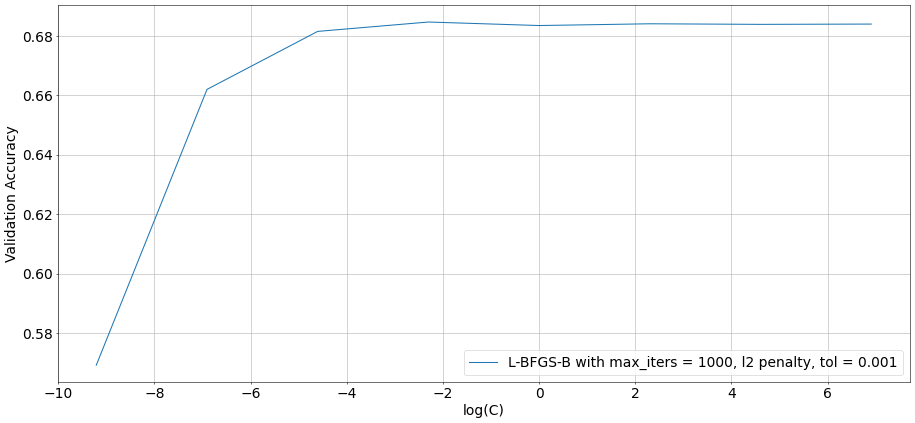

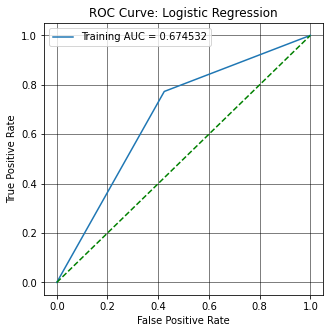

In [9]:
eval_params = np.array(eval_params)
p_opt = eval_params[np.argmax(eval_params[:,len(eval_params[0])-1])]
print('Optimally Tuned Parameters: [penalty, tol, C] = ', p_opt[0:len(eval_params[0])-1])
print('Optimal Validation Accuracy: = ',p_opt[len(eval_params[0])-1],'\n')
print('Accuracies for all Parameter Combinations:')
print(eval_params,'\n')

with open("file.txt", 'w') as output:
    for row in eval_params:
        output.write(str(row) + '\n')

# Plotting hyperparameters vs validation accuracy (recorded)
Cs = [10**-4, 10**-3, 10**-2, 0.1, 1, 10, 100, 1000]
accuracy_Cs = [0.5691589, 0.661997, 0.6815304, 0.684686, 0.683502, 0.6840944, 0.683897, 0.6839958]
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=1, ncols=1); fig.set_size_inches(22, 10); fig.set_dpi(50);
plt.subplot(1,1,1)
plt.plot(np.log(Cs), accuracy_Cs); plt.grid();
plt.legend(['L-BFGS-B with max_iters = 1000, l2 penalty, tol = 0.001'])
plt.xlabel('log(C)'); plt.ylabel('Validation Accuracy');

# Plotting ROC curve for training data set
clf = LogisticRegression(penalty = p_opt[0], tol = float(p_opt[1]), C = float(p_opt[2]), max_iter = 1000)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
train_fpr,train_tpr,_ = roc_curve(y_train, y_train_pred)
plt.rcParams.update({'font.size': 10}); plt.figure(figsize=(5,5));
plt.plot(train_fpr, train_tpr, label= "Training AUC = %f" %auc(train_fpr, train_tpr))
plt.plot([0,1],[0,1],'g--')
plt.legend(); plt.grid();
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Test Set Prediction

In [10]:
# Fit optimal hyperparameters to logistic regression model
clf = LogisticRegression(penalty = p_opt[0], tol = float(p_opt[1]), C = float(p_opt[2]), max_iter = 1000)

# Obtain predictions on the test set
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

import csv
from itertools import zip_longest
d = [id, y_pred]
export_data = zip_longest(*d, fillvalue = '')
with open('Logistic Regression.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
      wr = csv.writer(myfile)
      wr.writerow(("id", "Decision"))
      wr.writerows(export_data)
myfile.close()